<a href="https://colab.research.google.com/github/hiwei93/rag-practice/blob/main/Chat_With_Documents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 文档数据的问答对话

## 安装依赖

In [1]:
!pip install langchain beautifulsoup4 spacy chromadb zhipuai --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.6/803.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 准备数据及各个 RAG 组件

### 数据加载及分割

In [2]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://pub.towardsai.net/advanced-rag-techniques-an-illustrated-overview-04d193d8fec6")
data = loader.load()

In [3]:
data[0].page_content[:500]

'Advanced RAG Techniques: an Illustrated Overview | by IVAN ILIN | Dec, 2023 | Towards AIOpen in appSign upSign inWriteSign upSign inGroningen, Martinitoren, where the article was composed in the peace of the NoorderplatsoenAdvanced RAG Techniques: an Illustrated OverviewIVAN ILIN·FollowPublished inTowards AI·19 min read·Dec 17, 2023--25ListenShareA comprehensive study of the advanced retrieval augmented generation techniques and algorithms, systemising various approaches. The article comes with '

In [3]:
from langchain.text_splitter import SpacyTextSplitter

text_splitter = SpacyTextSplitter(chunk_size=500, chunk_overlap=50)
docs = text_splitter.split_documents(data)

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
len(docs)

74

### embedding 文本块及向量存储

In [4]:
from google.colab import userdata

# 获取 Huggingface token
inference_api_key = userdata.get('hf_token')

In [5]:
from langchain_community.embeddings import HuggingFaceInferenceAPIEmbeddings

embedding = HuggingFaceInferenceAPIEmbeddings(
    api_key=inference_api_key, model_name="intfloat/multilingual-e5-large"
)

In [6]:
from langchain_community.vectorstores import Chroma

vectordb = Chroma.from_documents(
    docs, embedding
)

In [8]:
vectordb._client.list_collections()

[Collection(name=langchain)]

In [ ]:
vectordb.similarity_search_with_relevance_scores("What's is RAG?")

In [7]:
from langchain.chat_models import ChatGooglePalm
llm = ChatGooglePalm(
    google_api_key=userdata.get('google_token'),
    model='gemini-pro'
)

In [13]:
llm.invoke("Who are you?")

ChatMessage(content='I am a large language model, also known as a conversational AI or chatbot trained to be informative and comprehensive. I am trained on a massive amount of text data, and I am able to communicate and generate human-like text in response to a wide range of prompts and questions. For example, I can provide summaries of factual topics or create stories.', role='1')

## 单轮 QA

In [ ]:
from langchain.prompts import PromptTemplate

# Build prompt
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer.
Tips: Make sure to cite your sources, and use the exact words from the context.
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

In [ ]:
from langchain.chains import RetrievalQA

basic_qa = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [ ]:
result = basic_qa.invoke({"query": "What's RAG?"})

In [ ]:
result

{'query': "What's RAG?",
 'result': 'Retrieval Augmented Generation (RAG) is a technique that uses information retrieved from a data source to ground the generation of an answer by a large language model (LLM). This is done by injecting both the query and the retrieved context into the prompt that is sent to the LLM. RAG is the most popular architecture of LLM-based systems in 2023.\n\nHere are some examples of RAG-based systems:\n\n* Question Answering services that combine web search engines with LLMs\n* Chat-with-your-data apps\n* Vector search engines\n\nRAG has been shown to be effective in a variety of tasks, including question answering, summarization, and translation. It is a promising technique for improving the performance of LLMs on a wide range of tasks.\n\nThanks for asking!',
 'source_documents': [Document(page_content='Retrieval Augmented Generation, aka RAG, provides LLMs with the information retrieved from some data source to ground its generated answer on.\n\nBasicall

## 对话问答（多轮 QA）

ConversationalRetrievalChain 逻辑：

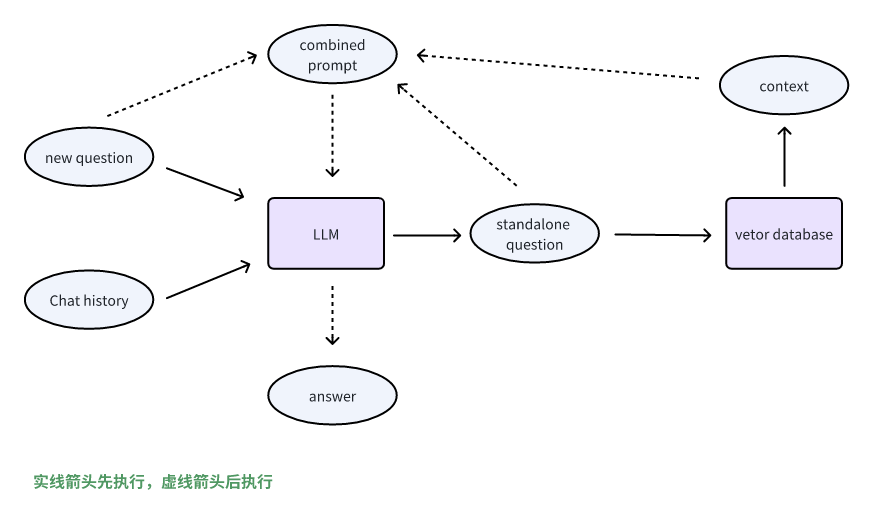

该方法主要解决的问题：平衡历史对话对新问题的影响
1. 直接使用新问题，则可能缺失对话上下文信息
2. 将历史对话全部使用，则可能引入无关内容

In [22]:
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

In [23]:
from langchain.chains import ConversationalRetrievalChain

qa = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=vectordb.as_retriever(),
    memory=memory,
    verbose=True,
)

In [24]:
qa.invoke({"question": "What's RAG?"})



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
Retrieval Augmented Generation, aka RAG, provides LLMs with the information retrieved from some data source to ground its generated answer on.

Basically RAG is Search + LLM prompting, where you ask the model to answer the query provided the information found with the search algorithm as a context.

Both the query and the retrieved context are injected into the prompt that is sent to the LLM.RAG is the most popular architecture of the LLM based systems in 2023.

There are many products build almost solely on RAG — from Question Answering services combining web search engines with LLMs to hundreds of chat-with-your-data apps.

Even the vector search area got pumped by that hype although embedding base

{'question': "What's RAG?",
 'chat_history': [HumanMessage(content="What's RAG?"),
  AIMessage(content='RAG stands for Retrieval Augmented Generation. It is a technique that uses a large language model (LLM) to generate text, but also uses information retrieved from a search engine to ground the generated text. This can be done by injecting the query and the retrieved context into the prompt that is sent to the LLM.\n\nRAG has been shown to be effective for a variety of tasks, including question answering, summarization, and translation. It is also being used to develop new applications, such as chatbots that can answer questions about real-world topics.\n\nOne of the advantages of RAG is that it can help to improve the accuracy of LLMs. When an LLM is given a query, it may not be able to generate a correct answer if it does not have enough information. However, if the LLM is given the query and the retrieved context, it can use this information to generate a more accurate answer.\n\nA

In [25]:
qa.invoke({"question": "What things RAG can do?"})



> Entering new LLMChain chain...
Prompt after formatting:
Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.

Chat History:

Human: What's RAG?
Assistant: RAG stands for Retrieval Augmented Generation. It is a technique that uses a large language model (LLM) to generate text, but also uses information retrieved from a search engine to ground the generated text. This can be done by injecting the query and the retrieved context into the prompt that is sent to the LLM.

RAG has been shown to be effective for a variety of tasks, including question answering, summarization, and translation. It is also being used to develop new applications, such as chatbots that can answer questions about real-world topics.

One of the advantages of RAG is that it can help to improve the accuracy of LLMs. When an LLM is given a query, it may not be able to generate a correct answer if it does not have enough inf

{'question': 'What things RAG can do?',
 'chat_history': [HumanMessage(content="What's RAG?"),
  AIMessage(content='RAG stands for Retrieval Augmented Generation. It is a technique that uses a large language model (LLM) to generate text, but also uses information retrieved from a search engine to ground the generated text. This can be done by injecting the query and the retrieved context into the prompt that is sent to the LLM.\n\nRAG has been shown to be effective for a variety of tasks, including question answering, summarization, and translation. It is also being used to develop new applications, such as chatbots that can answer questions about real-world topics.\n\nOne of the advantages of RAG is that it can help to improve the accuracy of LLMs. When an LLM is given a query, it may not be able to generate a correct answer if it does not have enough information. However, if the LLM is given the query and the retrieved context, it can use this information to generate a more accurate 